<a href="https://colab.research.google.com/github/bm23abb/7PAM2002-0509-2023---Data-Science-Project/blob/main/7PAM2002_0509_2023_Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MOUNTING GOOGLE DRIVE**

In [6]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORTING LIBRARIES**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from tabulate import tabulate

**LOADING DATASET**

In [8]:
file_path = '/content/drive/MyDrive/7PAM2002-0509-2023-Data-Science-Project/Data-Science-Project/Bitcoin.csv'
data_frame = pd.read_csv(file_path)
print("Last few rows of the dataset:")
print(tabulate(data_frame.tail(), headers='keys', tablefmt='grid'))

Last few rows of the dataset:
+------+------------+---------+---------+---------+---------+-------------+-------------+
|      | Date       |    Open |    High |     Low |   Close |   Adj Close |      Volume |
+======+============+=========+=========+=========+=========+=============+=============+
| 2678 | 2022-01-16 | 43172   | 43436.8 | 42691   | 43113.9 |     43113.9 | 17902097845 |
+------+------------+---------+---------+---------+---------+-------------+-------------+
| 2679 | 2022-01-17 | 43118.1 | 43179.4 | 41680.3 | 42250.6 |     42250.6 | 21690904261 |
+------+------------+---------+---------+---------+---------+-------------+-------------+
| 2680 | 2022-01-18 | 42250.1 | 42534.4 | 41392.2 | 42375.6 |     42375.6 | 22417209227 |
+------+------------+---------+---------+---------+---------+-------------+-------------+
| 2681 | 2022-01-19 | 42374   | 42478.3 | 41242.9 | 41744.3 |     41744.3 | 23091543258 |
+------+------------+---------+---------+---------+---------+---------

**PREPROCESSING THE DATA**

In [9]:
data_frame['Date'] = pd.to_datetime(data_frame['Date'])
data_frame.set_index('Date', inplace=True)
data_frame = data_frame.sort_values('Date')
data_frame = data_frame.fillna(method='ffill')
data_frame['Year'] = data_frame.index.year
data_frame['Month'] = data_frame.index.month
data_frame['Day'] = data_frame.index.day
data_frame['DayOfWeek'] = data_frame.index.dayofweek

**PREPARING CLOSE PRICE**

In [10]:
pforp = data_frame['Close'].values.reshape(-1,1)
print("Last few rows of the preprocessed dataset:")
print(tabulate(data_frame.tail(), headers='keys', tablefmt='grid'))

Last few rows of the preprocessed dataset:
+---------------------+---------+---------+---------+---------+-------------+-------------+--------+---------+-------+-------------+
| Date                |    Open |    High |     Low |   Close |   Adj Close |      Volume |   Year |   Month |   Day |   DayOfWeek |
+=====================+=========+=========+=========+=========+=============+=============+========+=========+=======+=============+
| 2022-01-16 00:00:00 | 43172   | 43436.8 | 42691   | 43113.9 |     43113.9 | 1.79021e+10 |   2022 |       1 |    16 |           6 |
+---------------------+---------+---------+---------+---------+-------------+-------------+--------+---------+-------+-------------+
| 2022-01-17 00:00:00 | 43118.1 | 43179.4 | 41680.3 | 42250.6 |     42250.6 | 2.16909e+10 |   2022 |       1 |    17 |           0 |
+---------------------+---------+---------+---------+---------+-------------+-------------+--------+---------+-------+-------------+
| 2022-01-18 00:00:00 | 42

**NORMALIZING THE CLOSE PRICE**

In [11]:
normalize = MinMaxScaler(feature_range=(0 ,1))
normalize_price = normalize.fit_transform(pforp)
n_p_df = pd.DataFrame(normalize_price, columns=['Normalize close'])
print("Last few rows of Min-Max Normalize prices:")
print(tabulate(n_p_df.head(), headers='keys', tablefmt="grid"))

Last few rows of Min-Max Normalize prices:
+----+-------------------+
|    |   Normalize close |
+====+===================+
|  0 |        0.00414359 |
+----+-------------------+
|  1 |        0.00365546 |
+----+-------------------+
|  2 |        0.00321557 |
+----+-------------------+
|  3 |        0.00342492 |
+----+-------------------+
|  4 |        0.0032753  |
+----+-------------------+


In [12]:
last_predict = np.arange(len(pforp)-7, len(pforp))
acutal_price = pforp[last_predict]

**CREATING THE DATASET FOR LSTM**

In [13]:
def create_datset(dataset, look_back=60):
  x, y = [], []
  for i in range(len(dataset) - look_back - 1):
    a = dataset[i:(i + look_back), 0]
    x.append(a)
    y.append(dataset[i + look_back, 0])
  return np.array(x), np.array(y)

**PREPARING TRAINING AND TESTING**

In [14]:
look_back = 60
x, y = create_datset(normalize_price, look_back)
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

**BUILDING AND RAINING THE LSTM MODEL**

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

2097/2097 [==============================] - 29s 11ms/step - loss: 1.9111e-04


**PREDICTION OF LAST 7 DAYS**

In [16]:
future_input = normalize_price[-(look_back+7):-7]
last7_days_lstm = []
for _ in range(7):
    future_input_reshaped = np.reshape(future_input, (1, look_back, 1))
    future_predict = model.predict(future_input_reshaped)
    last7_days_lstm.append(future_predict[0, 0])
    future_input = np.append(future_input[1:], future_predict)
last7_days_lstm = np.array(last7_days_lstm).reshape(-1, 1)
last7_days_lstm = normalize.inverse_transform(last7_days_lstm)

1/1 [==============================] - 0s 18ms/step


In [17]:
arima_model = ARIMA(pforp, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_last_predict = arima_result.predict(steps=last_predict[0], end=last_predict[-1])
arima_last_predict = arima_last_predict.reshape(-1, 1)

In [18]:
bayesian_model = BayesianRidge()
bayesian_model.fit(np.arange(len(pforp)).reshape(-1, 1), pforp.flatten())
future_in = np.arange(len(pforp), len(pforp) + 7).reshape(-1, 1)
bayesian_last_predict = bayesian_model.predict(np.array(last_predict).reshape(-1, 1)).reshape(-1, 1)

In [19]:
# Predictions for the last 7 days with Prophet
prophet_df = data_frame.reset_index()[['Date', 'Close']]
prophet_df.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future_dates_df = pd.DataFrame({'ds': data_frame.index[-7:]})
prophet_forecast = prophet_model.predict(future_dates_df)
prophet_predict = prophet_forecast[['yhat']].values
prophet_predict = np.array(prophet_predict).reshape(-1, 1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjpkwh4t0/zg4vawcv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjpkwh4t0/no_3n6gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77782', 'data', 'file=/tmp/tmpjpkwh4t0/zg4vawcv.json', 'init=/tmp/tmpjpkwh4t0/no_3n6gd.json', 'output', 'file=/tmp/tmpjpkwh4t0/prophet_modelsc3ptgp_/prophet_model-20240719141747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:17:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:17:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
# Print predictions and actual prices
predict = pd.DataFrame({
    'Date': data_frame.index[last_predict],
    'Actual': acutal_price.flatten(),
    'LSTM_Prediction': last7_days_lstm.flatten(),
    'ARIMA_Prediction': arima_last_predict[-7:].flatten(), # Select last 7 days of ARIMA predictions
    'BayesianRidge_Prediction': bayesian_last_predict.flatten(),
    'Prophet_Prediction': prophet_predict.flatten()
})
print("Predictions for the last 7 days:")
print(tabulate(predict, headers='keys', tablefmt='grid')) # Use 'predict' instead of 'predictions_df'

Predictions for the last 7 days:
+----+---------------------+----------+-------------------+--------------------+----------------------------+----------------------+
|    | Date                |   Actual |   LSTM_Prediction |   ARIMA_Prediction |   BayesianRidge_Prediction |   Prophet_Prediction |
+====+=====================+==========+===================+====================+============================+======================+
|  0 | 2022-01-14 00:00:00 |  43099.7 |           43398.6 |            42653.3 |                    31600.9 |              60070.8 |
+----+---------------------+----------+-------------------+--------------------+----------------------------+----------------------+
|  1 | 2022-01-15 00:00:00 |  43177.4 |           43668.9 |            43130.8 |                    31616.3 |              60187.6 |
+----+---------------------+----------+-------------------+--------------------+----------------------------+----------------------+
|  2 | 2022-01-16 00:00:00 |  43113.

In [47]:
mae_lstm = mean_absolute_error(predict['Actual'], predict['LSTM_Prediction'])
mae_arima = mean_absolute_error(predict['Actual'], predict['ARIMA_Prediction'])
mae_bayesian = mean_absolute_error(predict['Actual'], predict['BayesianRidge_Prediction'])
mae_prophet = mean_absolute_error(predict['Actual'], predict['Prophet_Prediction'])

In [48]:
print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"ARIMA MAE: {mae_arima:.2f}")
print(f"BayesianRidge MAE: {mae_bayesian:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")

LSTM MAE: 1698.14
ARIMA MAE: 340.13
BayesianRidge MAE: 10880.69
Prophet MAE: 17867.78


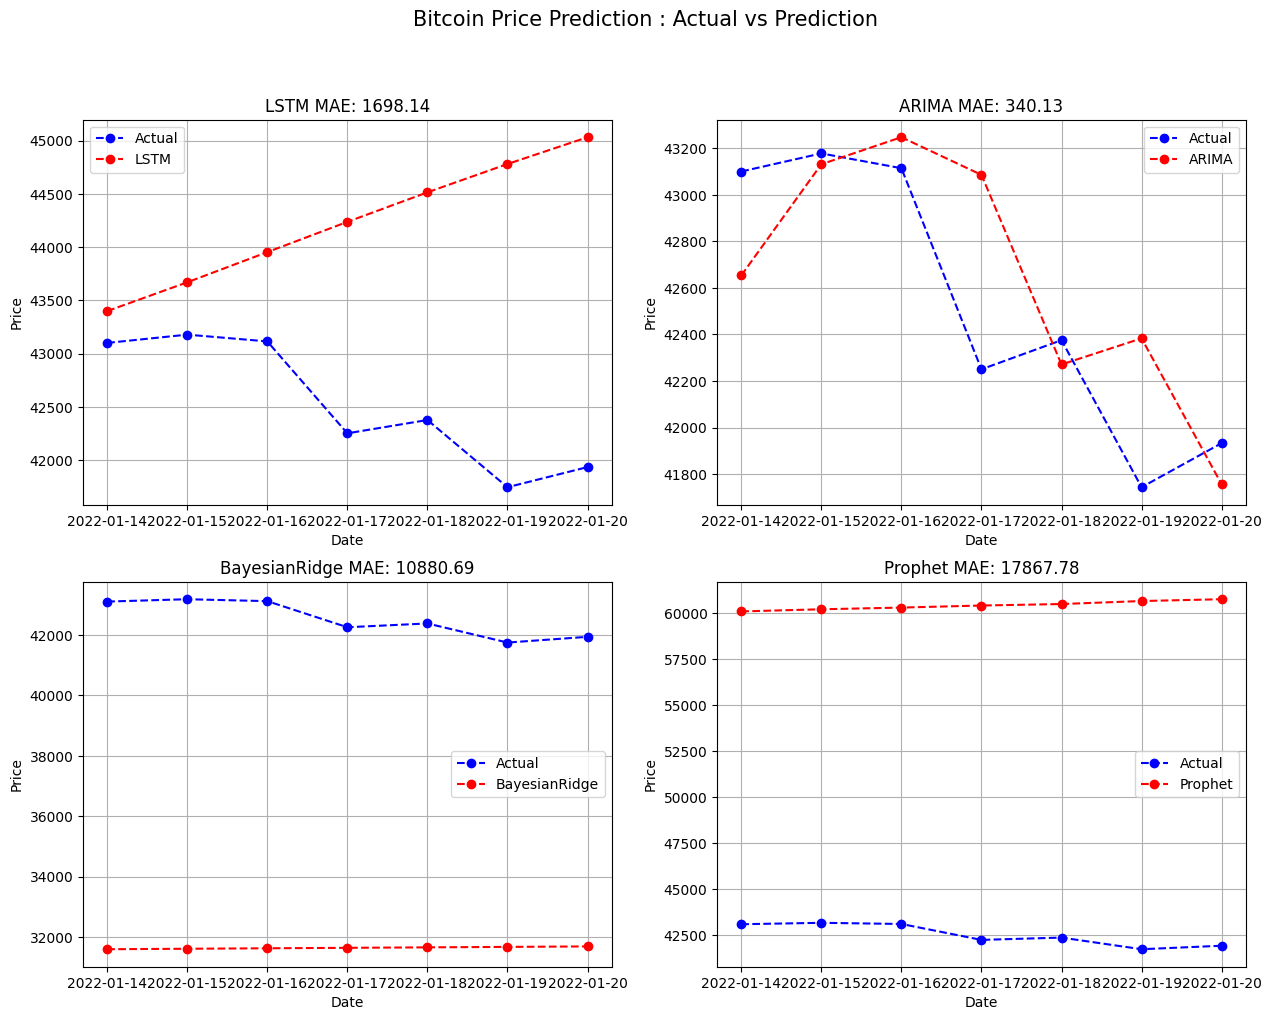

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,11))
fig.suptitle('Bitcoin Price Prediction : Actual vs Prediction', fontsize = 15)

#plot for LSTM
axes[0, 0].plot(predict['Date'], predict['Actual'], label='Actual', marker='o', linestyle='--', color='b')
axes[0, 0].plot(predict['Date'], predict['LSTM_Prediction'], label='LSTM', marker='o', linestyle='--', color='r')
axes[0, 0].set_title(f"LSTM MAE: {mae_lstm:.2f}")
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')
axes[0 , 0].legend()
axes[0, 0].grid(True)

#plot for ARIMA
axes[0, 1].plot(predict['Date'], predict['Actual'], label='Actual', marker='o', linestyle='--', color='b')
axes[0, 1].plot(predict['Date'], predict['ARIMA_Prediction'], label='ARIMA', marker='o', linestyle='--', color='r')
axes[0, 1].set_title(f"ARIMA MAE: {mae_arima:.2f}")
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Price')
axes[0 ,1].legend()
axes[0, 1].grid(True)

#plot for BayesianRidge
axes[1, 0].plot(predict['Date'], predict['Actual'], label='Actual', marker='o', linestyle='--', color='b')
axes[1, 0].plot(predict['Date'], predict['BayesianRidge_Prediction'], label='BayesianRidge', marker='o', linestyle='--', color='r')
axes[1, 0].set_title(f"BayesianRidge MAE: {mae_bayesian:.2f}")
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Price')
axes[1, 0].legend()
axes[1, 0].grid(True)

#plot for Prophet
axes[1, 1].plot(predict['Date'], predict['Actual'], label='Actual', marker='o', linestyle='--', color='b') # Use correct axes index
axes[1, 1].plot(predict['Date'], predict['Prophet_Prediction'], label='Prophet', marker='o', linestyle='--', color='r')
axes[1, 1].set_title(f"Prophet MAE: {mae_prophet:.2f}")
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Price')
axes[1 ,1].legend()
axes[1, 1].grid(True)

plt.show()

**PREDICTIONS IN LSTM**

In [23]:
future_date = 7
future_input = normalize_price[-look_back:]
future_predict_lstm = []
for _ in range(future_date):
    future_input_reshaped = np.reshape(future_input, (1, look_back, 1))
    future_predict = model.predict(future_input_reshaped)
    future_predict_lstm.append(future_predict[0, 0])
    future_input = np.append(future_input[1:], future_predict)

future_predict_lstm = normalize.inverse_transform(np.array(future_predict_lstm).reshape(-1, 1))
future_dates = pd.date_range(start=data_frame.index[-1] + pd.DateOffset(days=1), periods=future_date, freq='D')
lstm_predict_df = pd.DataFrame({
        'Date': future_dates,
        'LSTM_Prediction': future_predict_lstm.flatten()
    })
print("LSTM Predictions for the next '7' days:")
print(tabulate(lstm_predict_df, headers='keys', tablefmt='grid'))

1/1 [==============================] - 0s 19ms/step
LSTM Predictions for the next '7' days:
+----+---------------------+-------------------+
|    | Date                |   LSTM_Prediction |
+====+=====================+===================+
|  0 | 2022-01-21 00:00:00 |           43134.9 |
+----+---------------------+-------------------+
|  1 | 2022-01-22 00:00:00 |           43228.6 |
+----+---------------------+-------------------+
|  2 | 2022-01-23 00:00:00 |           43431.1 |
+----+---------------------+-------------------+
|  3 | 2022-01-24 00:00:00 |           43678.2 |
+----+---------------------+-------------------+
|  4 | 2022-01-25 00:00:00 |           43941.1 |
+----+---------------------+-------------------+
|  5 | 2022-01-26 00:00:00 |           44206   |
+----+---------------------+-------------------+
|  6 | 2022-01-27 00:00:00 |           44465.6 |
+----+---------------------+-------------------+


**PREDICTIONS IN ARIMA**

In [24]:
arima_model = ARIMA(pforp, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=future_date).reshape(-1, 1)
arima_predict_df = pd.DataFrame({
        'Date': future_dates,
         'ARIMA_Predictions':arima_forecast.flatten()
    })
print("ARIMA Predictions for the next '7' days:")
print(tabulate(arima_predict_df, headers='keys', tablefmt='grid'))

ARIMA Predictions for the next '7' days:
+----+---------------------+---------------------+
|    | Date                |   ARIMA_Predictions |
+====+=====================+=====================+
|  0 | 2022-01-21 00:00:00 |             41880.9 |
+----+---------------------+---------------------+
|  1 | 2022-01-22 00:00:00 |             41861.5 |
+----+---------------------+---------------------+
|  2 | 2022-01-23 00:00:00 |             41835.8 |
+----+---------------------+---------------------+
|  3 | 2022-01-24 00:00:00 |             41829.3 |
+----+---------------------+---------------------+
|  4 | 2022-01-25 00:00:00 |             41831.4 |
+----+---------------------+---------------------+
|  5 | 2022-01-26 00:00:00 |             41828.7 |
+----+---------------------+---------------------+
|  6 | 2022-01-27 00:00:00 |             41827   |
+----+---------------------+---------------------+


**PREDICTIONS IN BAYESIAN RIDGE**

In [25]:
bayesian_model = BayesianRidge()
bayesian_model.fit(np.arange(len(pforp)).reshape(-1, 1), pforp.flatten())
future_in = np.arange(len(pforp), len(pforp) + future_date).reshape(-1, 1)
bayesian_forcest = bayesian_model.predict(future_in).reshape(-1, 1)
bayesian_predict_df = pd.DataFrame({
        'Date': future_dates,
        'BayesianRidge_Prediction': bayesian_forcest.flatten()
    })
print("BayesianRidge Predictions for the next '7' days:")
print(tabulate(bayesian_predict_df, headers='keys', tablefmt='grid'))

BayesianRidge Predictions for the next '7' days:
+----+---------------------+----------------------------+
|    | Date                |   BayesianRidge_Prediction |
+====+=====================+============================+
|  0 | 2022-01-21 00:00:00 |                    31708.9 |
+----+---------------------+----------------------------+
|  1 | 2022-01-22 00:00:00 |                    31724.3 |
+----+---------------------+----------------------------+
|  2 | 2022-01-23 00:00:00 |                    31739.7 |
+----+---------------------+----------------------------+
|  3 | 2022-01-24 00:00:00 |                    31755.2 |
+----+---------------------+----------------------------+
|  4 | 2022-01-25 00:00:00 |                    31770.6 |
+----+---------------------+----------------------------+
|  5 | 2022-01-26 00:00:00 |                    31786   |
+----+---------------------+----------------------------+
|  6 | 2022-01-27 00:00:00 |                    31801.5 |
+----+-----------------

In [26]:
# Prophet model predictions for the next 7 days
future_dates_df_next = pd.DataFrame({
    'ds': pd.date_range(start=data_frame.index[-1] + pd.DateOffset(days=1), periods=7, freq='D')
})
prophet_forecast_next = prophet_model.predict(future_dates_df_next)
prophet_predict_next = prophet_forecast_next[['yhat']].values
prophet_predict_df = pd.DataFrame({
        'Date': future_dates,
        'prophet_Prediction': prophet_predict_next.flatten()
    })
print("prophet Predictions for the next '7' days:")
print(tabulate(prophet_predict_df, headers='keys', tablefmt='grid'))

prophet Predictions for the next '7' days:
+----+---------------------+----------------------+
|    | Date                |   prophet_Prediction |
+====+=====================+======================+
|  0 | 2022-01-21 00:00:00 |              60949.3 |
+----+---------------------+----------------------+
|  1 | 2022-01-22 00:00:00 |              61117.3 |
+----+---------------------+----------------------+
|  2 | 2022-01-23 00:00:00 |              61263.6 |
+----+---------------------+----------------------+
|  3 | 2022-01-24 00:00:00 |              61431.1 |
+----+---------------------+----------------------+
|  4 | 2022-01-25 00:00:00 |              61569   |
+----+---------------------+----------------------+
|  5 | 2022-01-26 00:00:00 |              61789.1 |
+----+---------------------+----------------------+
|  6 | 2022-01-27 00:00:00 |              61944.7 |
+----+---------------------+----------------------+


In [27]:
combined_df = pd.concat([bayesian_predict_df, arima_predict_df['ARIMA_Predictions'], lstm_predict_df['LSTM_Prediction'],prophet_predict_df['prophet_Prediction']], axis=1)
combined_df.columns = ['Date', 'BayesianRidge_Prediction', 'ARIMA_Predictions', 'LSTM_Predictions', 'prophet_Prediction']
print(tabulate(combined_df, headers='keys', tablefmt='grid'))

+----+---------------------+----------------------------+---------------------+--------------------+----------------------+
|    | Date                |   BayesianRidge_Prediction |   ARIMA_Predictions |   LSTM_Predictions |   prophet_Prediction |
+====+=====================+============================+=====================+====================+======================+
|  0 | 2022-01-21 00:00:00 |                    31708.9 |             41880.9 |            43134.9 |              60949.3 |
+----+---------------------+----------------------------+---------------------+--------------------+----------------------+
|  1 | 2022-01-22 00:00:00 |                    31724.3 |             41861.5 |            43228.6 |              61117.3 |
+----+---------------------+----------------------------+---------------------+--------------------+----------------------+
|  2 | 2022-01-23 00:00:00 |                    31739.7 |             41835.8 |            43431.1 |              61263.6 |
+----+--

**BAR PLOTS FOR PREDICTIONS**

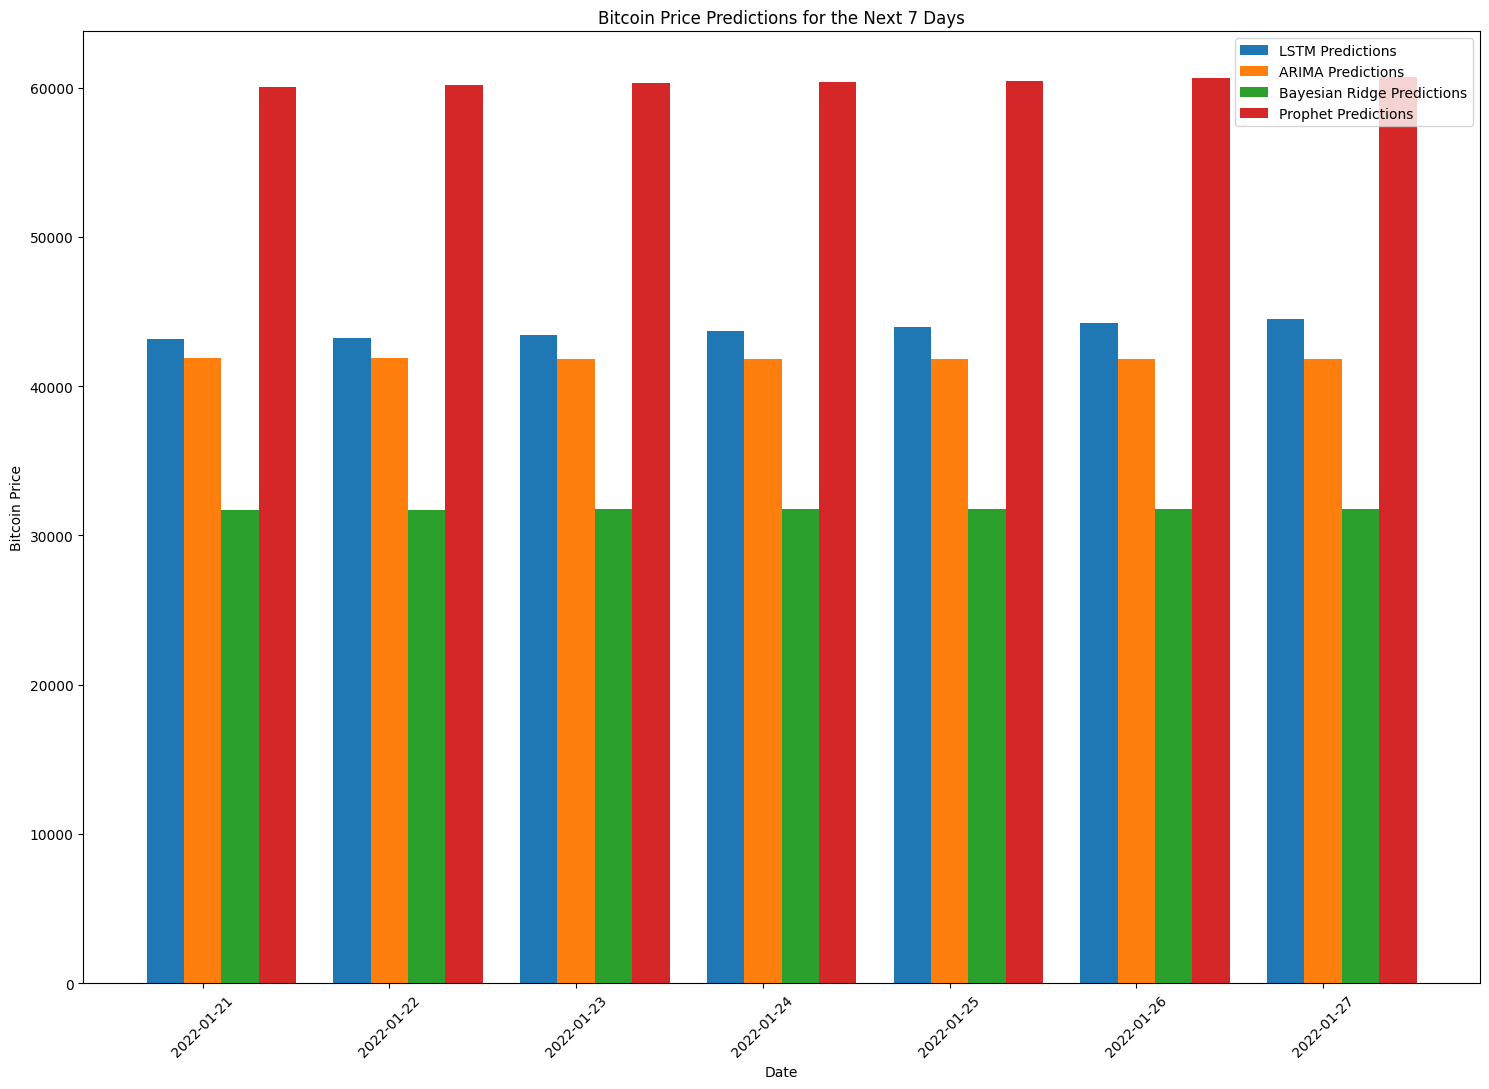

In [54]:
plt.figure(figsize=(15, 11))
bar_width = 0.20
index = np.arange(len(future_dates))
plt.bar(index, future_predict_lstm.flatten(), bar_width, label='LSTM Predictions')
plt.bar(index + bar_width, arima_forecast.flatten(), bar_width, label='ARIMA Predictions')
plt.bar(index + 2 * bar_width, bayesian_forcest.flatten(), bar_width, label='Bayesian Ridge Predictions')
plt.bar(index + 3 * bar_width, prophet_predict.flatten(), bar_width, label='Prophet Predictions')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Predictions for the Next 7 Days')
plt.xticks(index + bar_width, future_dates.strftime('%Y-%m-%d'), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()